# Deep Learning & Attribution Modeling Assignment

I'll try to construct classifier based on Convolutional autoencoder

https://www.datacamp.com/community/tutorials/autoencoder-classifier-python

Data: 
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

It is from this website: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


In [1]:
#from #import keras
import os
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.image import central_crop
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils import to_categorical
import cv2
from numpy import savez_compressed

from pprint import pprint

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_logical_devices('GPU')


Num GPUs Available:  2


Using TensorFlow backend.


I have rescaled and stored the data in numpy complressed form for the speed of the iterations.
I also used https://www.tensorflow.org/api_docs/python/tf/image/central_crop to `zoom` the %75 of the center of the picture.
This attempt uses image rescaled to 128px

In [10]:
## load data of converted images from NPZ
X_train = np.load("X_train-pneunonia-grayscale-(5216, 288, 288, 1).npz")['arr_0']
y_train = np.load("Y_train-pneunonia-grayscale-(5216, 288, 288, 1).npz")['arr_0']
X_val = np.load("X_val-pneunonia-grayscale-(16, 288, 288, 1).npz")['arr_0']
y_val = np.load("Y_val-pneunonia-grayscale-(16, 288, 288, 1).npz")['arr_0']
X_test = np.load("X_test-pneunonia-grayscale-(624, 288, 288, 1).npz")['arr_0']
y_test = np.load("Y_test-pneunonia-grayscale-(624, 288, 288, 1).npz")['arr_0']


# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)
y_valHot = to_categorical(y_val, num_classes = 2)


128


Concatenate all data

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X = np.concatenate((X_train, np.concatenate((X_test, X_val), axis=0)), axis=0)
Y = np.concatenate((y_train, np.concatenate((y_test, y_val), axis=0)), axis=0)

print(X.shape)
print(Y.shape)


(5216, 288, 288, 1)
(5216,)
(624, 288, 288, 1)
(624,)
(5856, 288, 288, 1)
(5856,)


## Use RandomUnderSampler to bring to balance the classes in dataset

In [15]:
# Deal with imbalanced class sizes
# Make Data 1D for compatability upsampling methods
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
X_ = X.shape[1]*X.shape[2]*X.shape[3]
print(X_)
X_Flat = X.reshape(X.shape[0], X_)
print(X_Flat.shape)

src_size  = 288
ros = RandomUnderSampler(sampling_strategy='auto')
X_ros, Y_ros = ros.fit_sample(X_Flat, Y)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_ros_hot = to_categorical(Y_ros, num_classes = 2)
# Make Data 2D again
height, width, channels = src_size,src_size,1
for i in range(len(X_ros)):
    X_ = X_ros.reshape(len(X_ros),height,width,channels)


82944
(5856, 82944)


{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


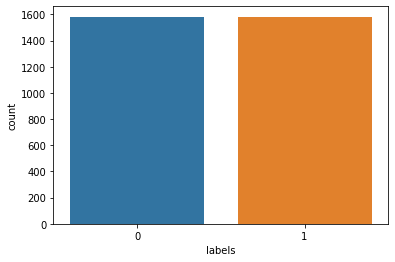

In [16]:
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_ros
labRos = dfRos['labels']
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
distRos = lab.value_counts()
# Plot Label Distribution
import seaborn
seaborn.countplot(labRos)
print({0: 'No Pneumonia', 1: 'Yes Pneumonia'})

## Split all data into test and training

In [67]:
print(X_.shape)
print(Y_ros.shape)
from sklearn.model_selection import train_test_split

train_X,valid_X,train_label,valid_label = train_test_split(X_,Y_ros,test_size=0.3,random_state=13)

print(train_X.shape)
print(valid_X.shape)
print(train_label.shape)
print(valid_label.shape)


(3166, 288, 288, 1)
(3166,)
(2216, 288, 288, 1)
(950, 288, 288, 1)
(2216,)
(950,)


Text(0.5, 1.0, '(Label: Yes)')

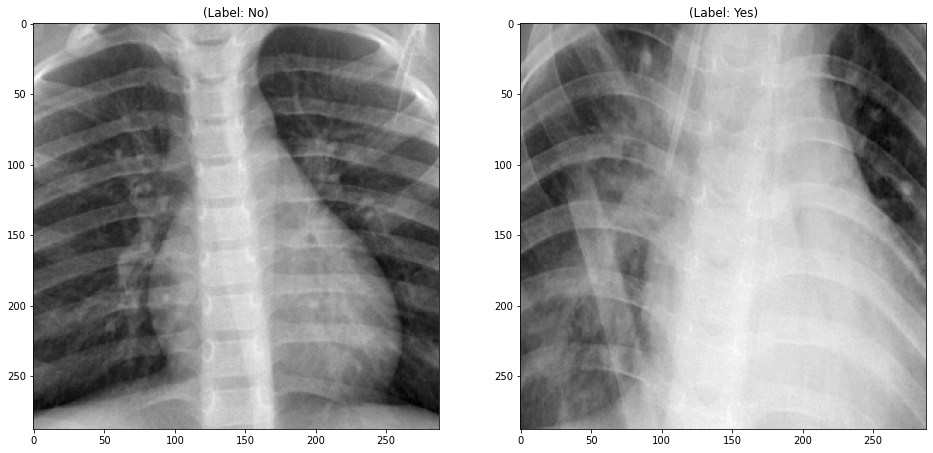

In [68]:
image_size = 288
# Create dictionary of target classes
label_dict = {
 0: 'No',
 1: 'Yes'
}
plt.figure(figsize=[16,16])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[10], (image_size,image_size))
curr_lbl = train_label[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[-20], (image_size,image_size))
curr_lbl = valid_label[-20]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [69]:
np.max(train_X), np.max(valid_X)

(255, 255)

In [70]:
train_X = train_X / np.max(train_X)
valid_X = valid_X / np.max(valid_X)

In [73]:
np.max(train_X), np.max(valid_X)

(1.0, 1.0)

In [74]:
train_X.dtype, valid_X.dtype

(dtype('float64'), dtype('float64'))

Split to train encdoer and decoder

In [77]:
from sklearn.model_selection import train_test_split
X_tr,X_ts,Y_tr, Y_ts = train_test_split(train_X,train_X,test_size=0.2, random_state=13)
from pprint import pprint
pprint(X_tr.shape)
pprint(X_ts.shape)
pprint(Y_tr.shape)
pprint(Y_ts.shape)

(1772, 288, 288, 1)
(444, 288, 288, 1)
(1772, 288, 288, 1)
(444, 288, 288, 1)


Train Encoder decoder for image of the 128px size

In [79]:
from tensorflow.image import resize as reZ
x, y = 128, 128
inChannel = 1

with tf.device('/GPU:0'):
    X_tr = reZ(X_tr,(128,128))
    print(X_tr.shape)
    X_ts =reZ(X_ts,(128,128))
    print(X_ts.shape)
    Y_tr = reZ(Y_tr,(128,128))
    print(Y_tr.shape)
    Y_ts = reZ(Y_ts,(128,128))
    print(Y_ts.shape)

batch_size = 16
epochs = 32


input_img = Input(shape = (x, y, inChannel))
print(input_img)
#tf.set_floatx('float16')
num_classes = 2

(1772, 128, 128, 1)
(444, 128, 128, 1)
(1772, 128, 128, 1)
(444, 128, 128, 1)
Tensor("input_4:0", shape=(None, 128, 128, 1), dtype=float32)


Define Encoder/Decoder

In [80]:
def encoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #image_size x image_size x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [81]:
with tf.device('/GPU:0'):
    autoencoder = Model(input_img, decoder(encoder(input_img)))
    autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(lr=0.005))


In [82]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_57 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 64)        1849

In [83]:
#filepath="weights-improvement-{epoch:02d}-{loss:.4f}-autoencoder-128.hdf5"
#weights_improvement = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True)
#callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1),weights_improvement]
with tf.device('/GPU:0'):
    autoencoder_train = autoencoder.fit(X_tr,Y_tr, batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(X_ts,Y_ts))
    autoencoder.save_weights("autoencoder-en-dec-128.h5")

Epoch 1/32
111/111 - 23s - loss: 0.0206 - val_loss: 0.3032
Epoch 2/32
111/111 - 23s - loss: 0.0079 - val_loss: 0.2488
Epoch 3/32
111/111 - 23s - loss: 0.0043 - val_loss: 0.0841
Epoch 4/32
111/111 - 23s - loss: 0.0028 - val_loss: 0.0340
Epoch 5/32
111/111 - 23s - loss: 0.0022 - val_loss: 0.0023
Epoch 6/32
111/111 - 23s - loss: 0.0018 - val_loss: 0.0094
Epoch 7/32
111/111 - 23s - loss: 0.0017 - val_loss: 0.0048
Epoch 8/32
111/111 - 23s - loss: 0.0016 - val_loss: 0.0116
Epoch 9/32
111/111 - 23s - loss: 0.0015 - val_loss: 0.0027
Epoch 10/32
111/111 - 23s - loss: 0.0015 - val_loss: 0.0046
Epoch 11/32
111/111 - 23s - loss: 0.0013 - val_loss: 0.0033
Epoch 12/32
111/111 - 23s - loss: 0.0013 - val_loss: 0.0020
Epoch 13/32
111/111 - 23s - loss: 0.0014 - val_loss: 0.0041
Epoch 14/32
111/111 - 23s - loss: 0.0013 - val_loss: 0.0035
Epoch 15/32
111/111 - 23s - loss: 0.0013 - val_loss: 0.0018
Epoch 16/32
111/111 - 23s - loss: 0.0014 - val_loss: 0.0047
Epoch 17/32
111/111 - 23s - loss: 0.0013 - val_lo

After training let's check the losses

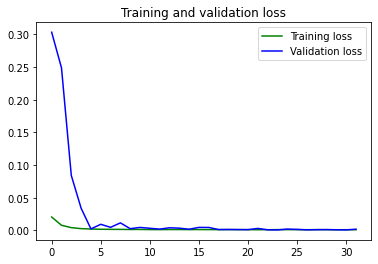

In [84]:

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_R = range(epochs)
plt.figure()
plt.plot(epochs_R, loss, 'g', label='Training loss')
plt.plot(epochs_R, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


Define Encoder again

In [85]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4


In [94]:
print(train_X.dtype)
print(valid_X.dtype)
print(train_label.shape)
print(valid_label.shape)

float64
float64
(2216,)
(950,)


In [95]:
# split data for classification
Y_tr_hot = to_categorical(train_label, num_classes = 2)
Y_val_hot = to_categorical(valid_label, num_classes = 2)

X_tr,X_ts,Y_tr, Y_ts = train_test_split(train_X,Y_tr_hot,test_size=0.2,random_state=13)

In [116]:
print(X_tr.shape)
print(X_ts.shape)
print(Y_tr.shape)
print(Y_ts.shape)

np.max(X_tr), np.max(X_ts)

(1772, 288, 288, 1)
(444, 288, 288, 1)
(1772, 2)
(444, 2)


(1.0, 1.0)

In [97]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(2, activation='sigmoid')(den)
    return out

In [98]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [99]:
autoencoder.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_57 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 64)        1849

In [100]:
full_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_70 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_71 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 64, 64, 64)        1849

In [101]:
i=0
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    pprint(l1)
    pprint(l2)
    print(i)
    i+=1
    l1.set_weights(l2.get_weights())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [102]:
autoencoder.get_weights()[0][1]

array([[[ 0.37350664, -0.01994546, -0.27978432,  0.57400805,
          0.22535543,  0.3536263 , -0.10767152,  0.36261848,
          0.09022646,  0.08933882,  0.13824405,  0.27090266,
          0.03708163,  0.3651863 , -0.13941   , -0.10117669,
          0.42804772, -0.05505278,  0.13365494, -0.46255916,
          0.30576438,  0.11159268, -0.0294117 , -0.08898286,
          0.62906224, -0.1245191 ,  0.40508842,  0.13438489,
          0.09601661, -0.02065923,  0.04123741,  0.00136226]],

       [[ 0.6058002 , -0.25684622,  0.31652853,  0.6545719 ,
          0.7946229 ,  0.35447046, -0.11384361,  0.81206214,
          0.7255517 ,  0.01770259,  0.97999585,  1.2587384 ,
          0.40343672,  0.4664614 , -0.14769784, -0.1054982 ,
          0.5973202 , -0.04266644,  0.8752916 ,  0.5889121 ,
          0.6118269 , -0.12406617,  0.05672728, -0.05711618,
          0.5437916 , -0.19860679,  0.7793091 ,  0.76241785,
          0.00271033,  0.536751  ,  0.14579834,  0.48572624]],

       [[ 0.206845

In [103]:
full_model.get_weights()[0][1]

array([[[ 0.37350664, -0.01994546, -0.27978432,  0.57400805,
          0.22535543,  0.3536263 , -0.10767152,  0.36261848,
          0.09022646,  0.08933882,  0.13824405,  0.27090266,
          0.03708163,  0.3651863 , -0.13941   , -0.10117669,
          0.42804772, -0.05505278,  0.13365494, -0.46255916,
          0.30576438,  0.11159268, -0.0294117 , -0.08898286,
          0.62906224, -0.1245191 ,  0.40508842,  0.13438489,
          0.09601661, -0.02065923,  0.04123741,  0.00136226]],

       [[ 0.6058002 , -0.25684622,  0.31652853,  0.6545719 ,
          0.7946229 ,  0.35447046, -0.11384361,  0.81206214,
          0.7255517 ,  0.01770259,  0.97999585,  1.2587384 ,
          0.40343672,  0.4664614 , -0.14769784, -0.1054982 ,
          0.5973202 , -0.04266644,  0.8752916 ,  0.5889121 ,
          0.6118269 , -0.12406617,  0.05672728, -0.05711618,
          0.5437916 , -0.19860679,  0.7793091 ,  0.76241785,
          0.00271033,  0.536751  ,  0.14579834,  0.48572624]],

       [[ 0.206845

### Freeze the first 20 layers

In [142]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [143]:
full_model.compile(loss="binary_crossentropy", optimizer = Adam(),metrics=['binary_accuracy','categorical_accuracy'])

In [144]:
full_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_70 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_71 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 64, 64, 64)        1849

In [145]:
#reZ(X_tr,(128,128))
X_tr.dtype

dtype('float64')

### Train classifier with Early Stop 

In [146]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-autoencoder-128.hdf5"
weights_improvement = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1),weights_improvement]
classify_train = full_model.fit(reZ(X_tr,(128,128)), Y_tr, batch_size=4,epochs=64,verbose=1,validation_data=(reZ(X_ts,(128,128)), Y_ts),callbacks = callbacks)
full_model.save_weights("autoencoder_classification-128.h5")

Epoch 1/64
442/443 [============================>.] - ETA: 0s - loss: 4070.4951 - binary_accuracy: 0.5950 - categorical_accuracy: 0.5967
Epoch 00001: val_loss improved from inf to 7053.68506, saving model to weights-improvement-01-4061.3115-autoencoder-128.hdf5
443/443 [==============================] - 26s 59ms/step - loss: 4061.3115 - binary_accuracy: 0.5951 - categorical_accuracy: 0.5971 - val_loss: 7053.6851 - val_binary_accuracy: 0.4809 - val_categorical_accuracy: 0.4797
Epoch 2/64
443/443 [==============================] - ETA: 0s - loss: 2536.6804 - binary_accuracy: 0.5539 - categorical_accuracy: 0.5559
Epoch 00002: val_loss did not improve from 7053.68506
443/443 [==============================] - 24s 55ms/step - loss: 2536.6804 - binary_accuracy: 0.5539 - categorical_accuracy: 0.5559 - val_loss: 7058.9243 - val_binary_accuracy: 0.4820 - val_categorical_accuracy: 0.4752
Epoch 3/64
443/443 [==============================] - ETA: 0s - loss: 858.5602 - binary_accuracy: 0.5288 - ca

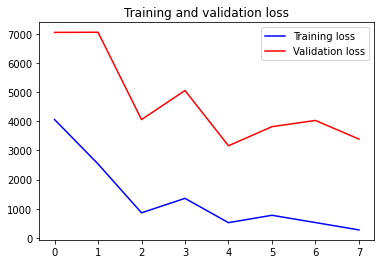

In [155]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def plot_learning_curve(history):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
def training_report(model,history,xtest,ytest):
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    pprint(score)
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list({0: 'No Pneumonia', 1: 'Yes Pneumonia'}.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list({0: 'No Pneumonia', 1: 'Yes Pneumonia'}.values()))
    plt.show()

import sklearn
import itertools
from sklearn.metrics import confusion_matrix

#training_report(full_model, classify_train, reZ(X_ts,(128,128)), Y_ts)
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(8)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()    


Looks like the trend is into the right direction!

### Unfreeze top layers

In [157]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

filepath="weights-improvement-{epoch:02d}-{loss:.4f}-autoencoder-classification-128.hdf5"
weights_improvement = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True)
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=2),weights_improvement]

full_model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy','binary_accuracy','categorical_accuracy'])
classify_train1 = full_model.fit(reZ(X_tr,(128,128)), Y_tr, batch_size=4,epochs=64,verbose=2,validation_data=(reZ(X_ts,(128,128)), Y_ts),callbacks = callbacks)

Epoch 1/64

Epoch 00001: val_loss improved from inf to 1778.46667, saving model to weights-improvement-01-0.6929-autoencoder-classification-128.hdf5
443/443 - 48s - loss: 0.6929 - accuracy: 0.5135 - binary_accuracy: 0.5135 - categorical_accuracy: 0.5135 - val_loss: 1778.4667 - val_accuracy: 0.4820 - val_binary_accuracy: 0.4831 - val_categorical_accuracy: 0.4820
Epoch 2/64

Epoch 00002: val_loss did not improve from 1778.46667
443/443 - 45s - loss: 0.6929 - accuracy: 0.5135 - binary_accuracy: 0.5135 - categorical_accuracy: 0.5135 - val_loss: 2468.6606 - val_accuracy: 0.4820 - val_binary_accuracy: 0.4842 - val_categorical_accuracy: 0.4820
Epoch 3/64

Epoch 00003: val_loss did not improve from 1778.46667
443/443 - 45s - loss: 0.6929 - accuracy: 0.5135 - binary_accuracy: 0.5135 - categorical_accuracy: 0.5135 - val_loss: 3663.3372 - val_accuracy: 0.4820 - val_binary_accuracy: 0.4842 - val_categorical_accuracy: 0.4820
Epoch 4/64

Epoch 00004: val_loss improved from 1778.46667 to 1512.56091, 


Keras CNN - accuracy: 0.5115789771080017 

[798.4292602539062, 0.5115789771080017, 0.5105262994766235, 0.5115789771080017]

               precision    recall  f1-score   support

 No Pneumonia       0.92      0.05      0.09       485
Yes Pneumonia       0.50      1.00      0.67       465

     accuracy                           0.51       950
    macro avg       0.71      0.52      0.38       950
 weighted avg       0.71      0.51      0.37       950



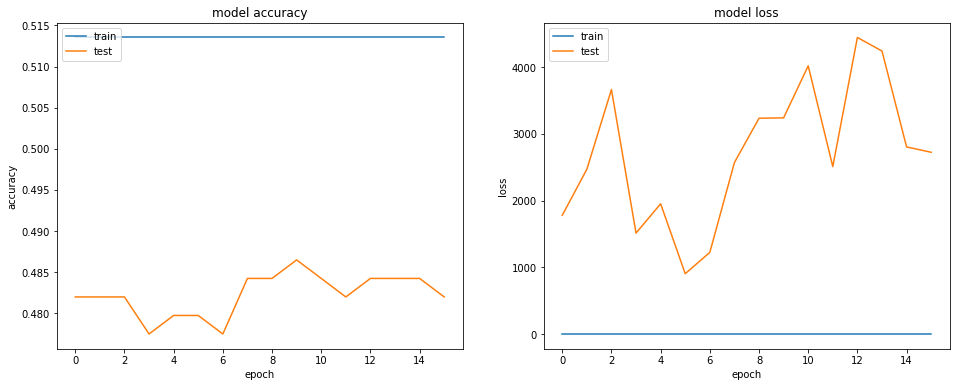

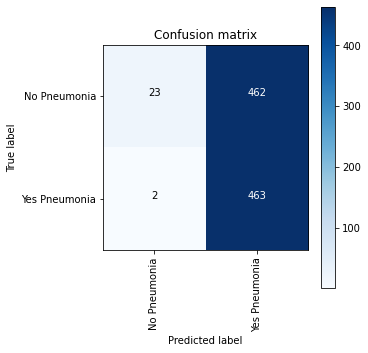

ValueError: x and y must have same first dimension, but have shapes (16,) and (8,)

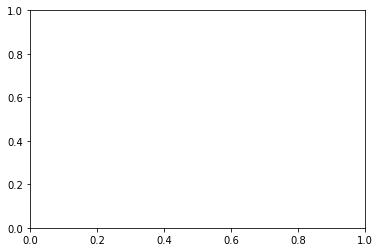

In [161]:
full_model.save_weights('autoencoder_classification+2+complete.h5')
training_report(full_model, classify_train1, reZ(valid_X,(128,128)), Y_val_hot)
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(16)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()  

Conclusion: the autoencoders are hard!
The possible reasons for failure: 
* autoencoder is not too deep: the original source works with 28x28 image
* autoencoder overfits the data to one class
* noisy images: all have pneumonia or no one! neet augmentation, contrast fitering etc.
* Need to compare resize/zoom with the models evaluated for semmester projects  

https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363